### Problem Statement:

For this project we will be building a model to predict the prices of AirBnBs in European cities which are popular among tourists. I want to explore how the prices of accommodation differ in different regions in Europe and what factors impact the price.

The dataset being used: https://zenodo.org/record/4446043#.ZAlnNXbMK5d 

This dataset offers a thorough view of Airbnb rates in some of the most well-known European cities. Each listing is assessed according to a number of factors, including the number of bedrooms, room kinds, cleanliness and satisfaction ratings, and how far it is from the city center, in order to gain a thorough grasp of Airbnb rates both during the week and on the weekends.


(Published: January,2021 | no information provided regarding what period of time the data was collected)

In [21]:
#read data
import pandas as pd
import os
from sklearn.utils import shuffle
 
# Get the list of all files and directories
path = "data/"
dir_list = os.listdir(path)
df_all = pd.DataFrame({})
for file in dir_list:
#     print('Reading data from: ', file)
    link = 'data/'+file
    city = file.split('_')[0]
    day = file.split('_')[1].split('.')[0]
    df = pd.read_csv(link, index_col=0)
    df['city'] = city
    df['day'] = day
    df_all = pd.concat([df, df_all])

df_all = shuffle(df_all)
# print(df_all.head())
# print(df_all.columns)
df_all.drop(['lng','lat', 'attr_index', 'rest_index', 'attr_index_norm','rest_index_norm'], axis=1, inplace=True)
print(df_all.isna().sum()) # no na values
df_all.dropna(inplace=True)
print('Shape: ', df_all.shape)
print(df_all.head())


realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
city                          0
day                           0
dtype: int64
Shape:  (51707, 15)
         realSum        room_type  room_shared  room_private  person_capacity  \
1242  166.513794     Private room        False          True              2.0   
695   266.460977  Entire home/apt        False         False              2.0   
1063  115.259626     Private room        False          True              2.0   
1035  150.580678     Private room        False          True              2.0   
631   799.235716  Entire home/apt        False         False              6.0   



In [77]:
df_all.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577


#### Dataset Features

The dataset above contains the following columns: 

1. realSum: price of accommodation for two people and two nights in EUR
2. room_type: the type of the accommodation. Type: Categorical (Entire home/apt, Private room, Shared room)
3. room_shared: If the rooms are shared. Type: Boolean 
4. room_private: If the rooms are private. Type: Boolean
5. person_capacity: the maximum number of guests. Type: int 
6. host_is_superhost: superhost status. Type: Boolean
7. multi: Whether the listing is for multiple rooms or not. Type: Boolean
8. biz: Whether the listing is for business purposes or not. Type: Boolean
9. cleanliness_rating: cleanliness rating. Type: int 
10. guest_satisfaction_overall: overall rating of the listing. Type: int 
11. bedrooms: number of bedrooms (0 for studios). Type: int
12. dist: distance from city centre in km. Type: int
13. metro_dist: distance from nearest metro station in km. Type: int
14. city: city in Europe. Type: Categorical (london, rome, paris, lisbon, athens, budapest, vienna, barcelona, berlin, amsterdam)
15. day: Day of the week. Type: Categorical (weekday, weekend) 


#### Data Exploration

In this section I will visualize the data, find corelations and check if we have enough data in each category to go ahead with building the model.

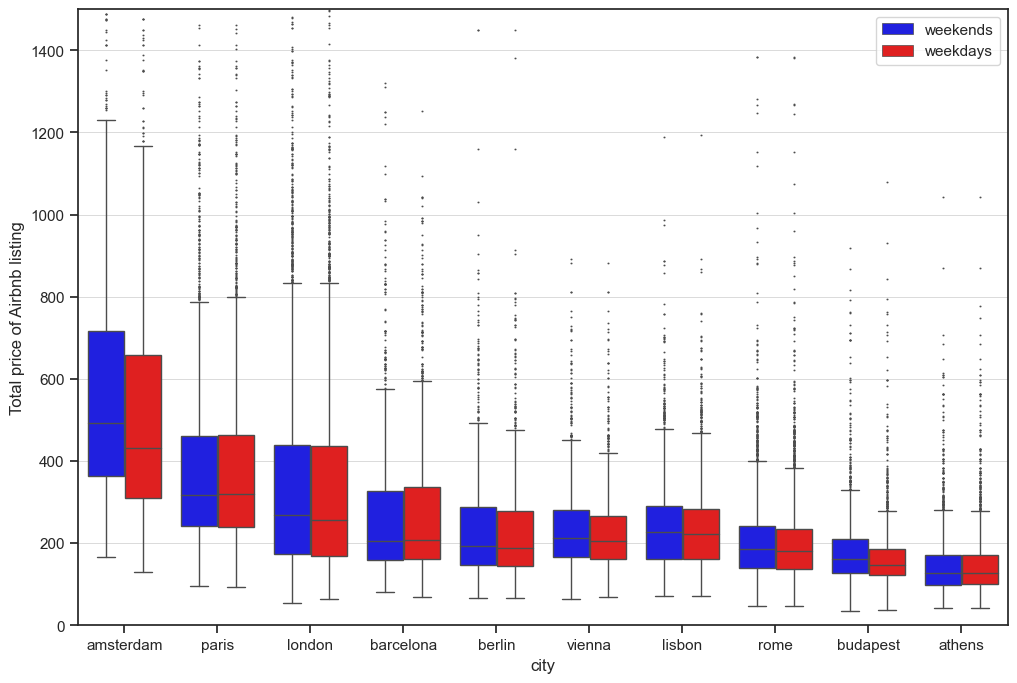

<Figure size 640x480 with 0 Axes>

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

ranks = df_all.groupby('city')['realSum'].mean().sort_values()[::-1].index
ranks
plt.figure(figsize=(12, 8))
ax = plt.subplot()
plt.axis([0,8,0,1500])
sns.boxplot(x="city", y="realSum", hue="day", palette=['blue', 'red'], 
            data=df_all, fliersize=0.5, linewidth=1, order=ranks)
plt.ylabel('Total price of Airbnb listing')
ax.set_xticklabels(ranks)
plt.grid(axis='y', linewidth=.5)
plt.legend(loc=1)
plt.show()
plt.clf()

We can see from this graph that the day of the week(weekend/weekday) does not impact the price significantly, apart from in Amsterdam. The price of the accommodation does show some relation to the different cities, for instance Amsterdam rates are higher than the rest, but there is significant overlap. 

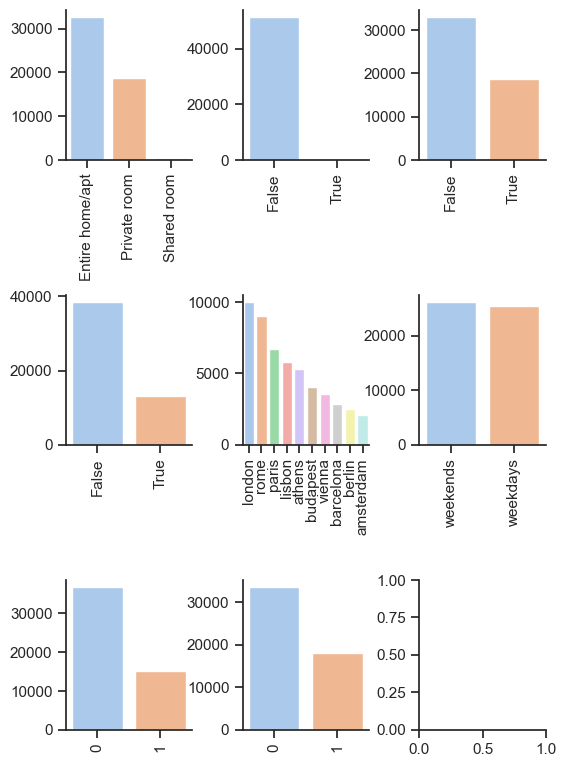

In [79]:
import math
# visualizing categorical splits
categorical=['room_type','room_shared','room_private','host_is_superhost','city','day','multi','biz']

m=math.ceil(math.sqrt(len(categorical)))
n=math.ceil(len(categorical)/m)
fig, axes = plt.subplots(m,n,figsize=(6,9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.9)

sns.despine()
for i in range(m):
    for j in range(n):
        sns.barplot(x= df_all[categorical[i*n+j]].value_counts().index,
                    y= df_all[categorical[i*n+j]].value_counts().values,
                   ax=axes[i,j])
        axes[i,j].tick_params(axis='x', labelrotation=90)
        
        if i*n+j==len(categorical)-1:
            break

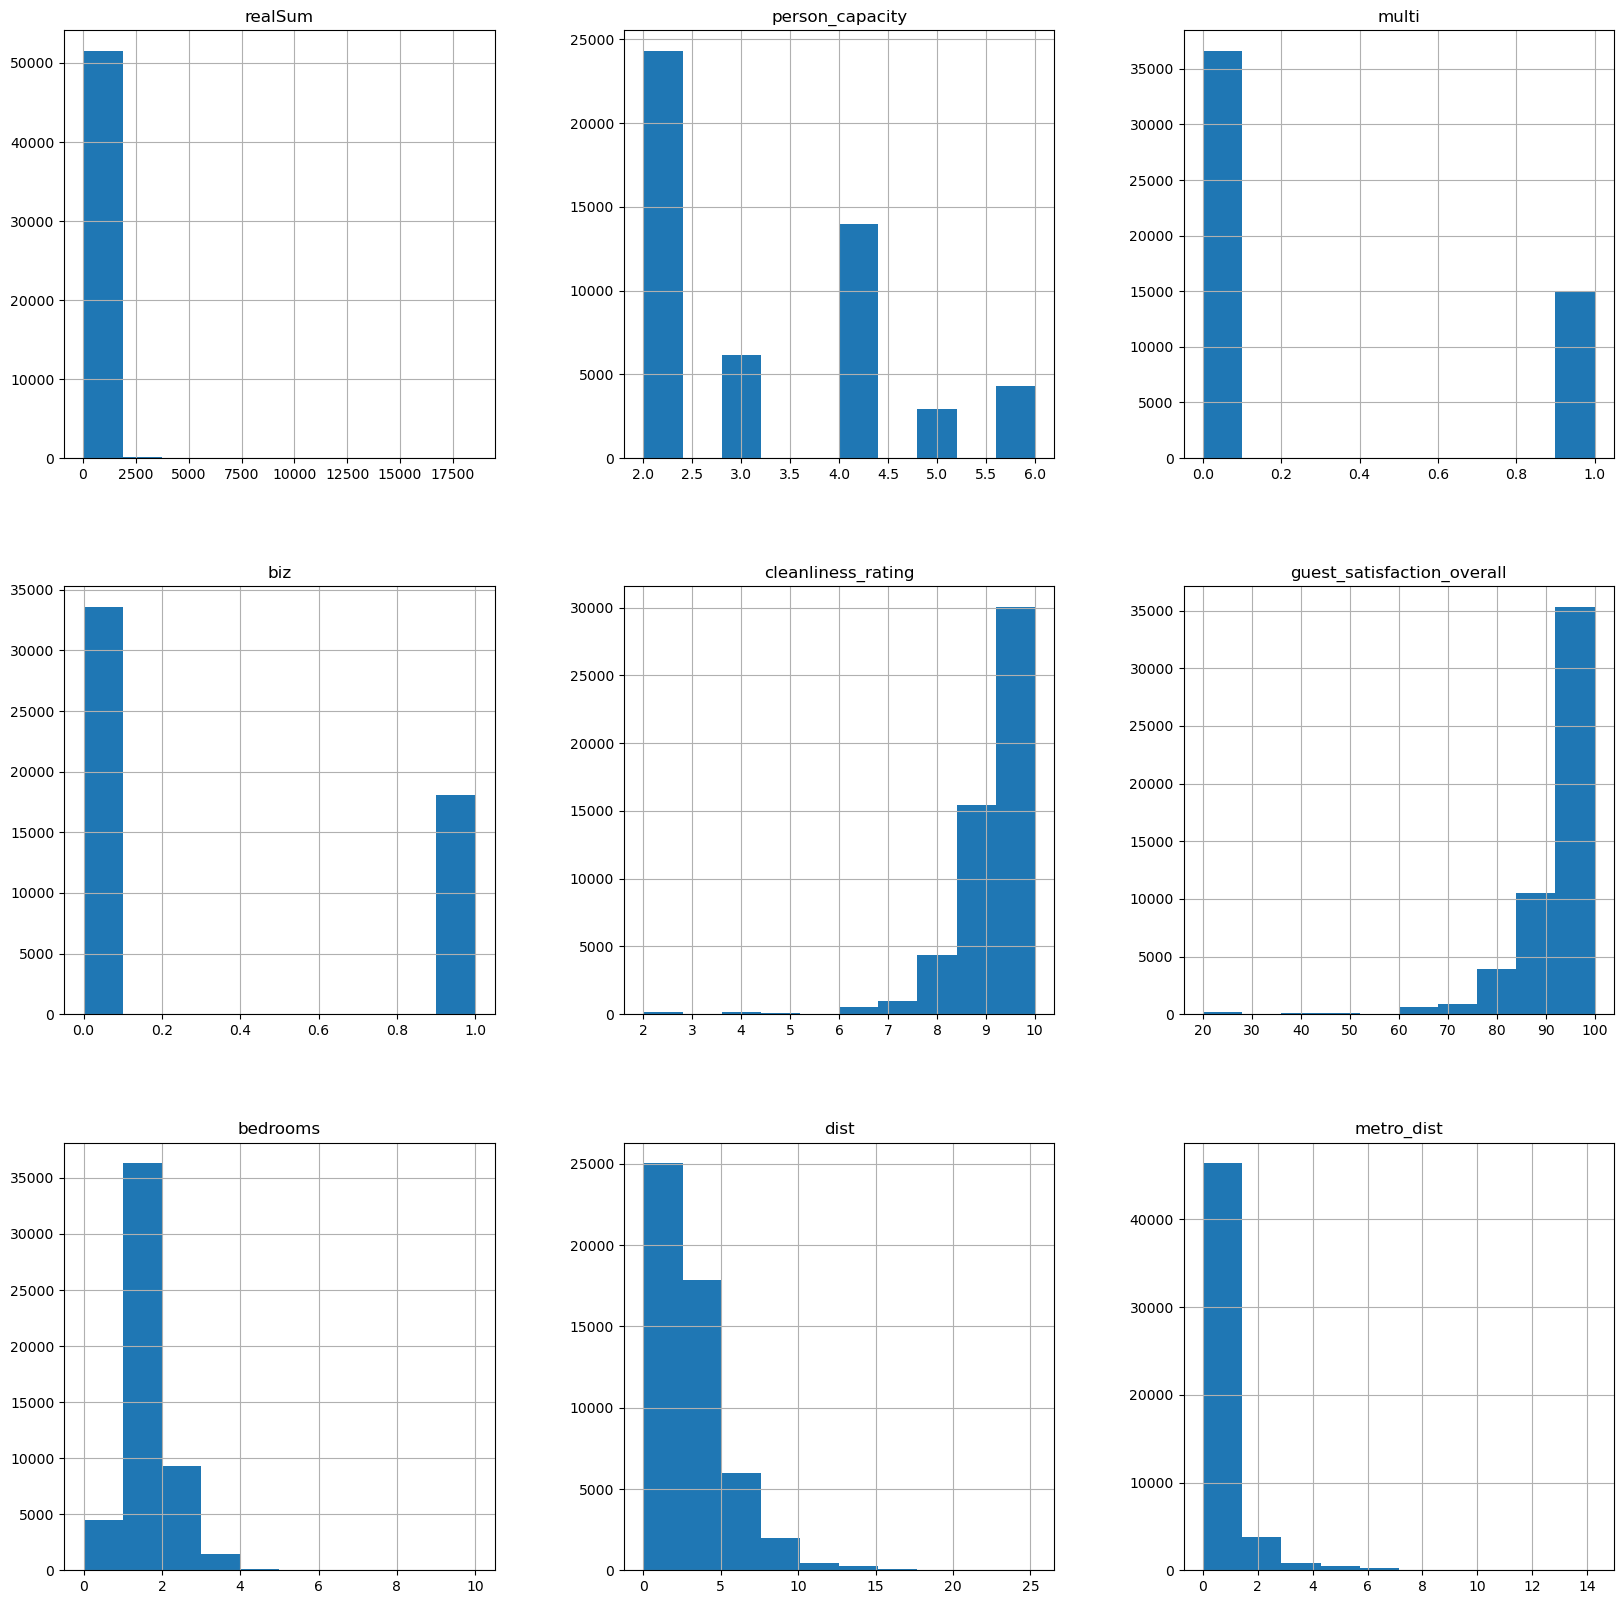

In [27]:
df_all.hist(figsize=(20,20));

The visualizations above show that we do have enough data in each category however some splits are not balanced well which might impact the model. For instance, in the column "room_type" the number on entries for "shared room" is very less compared to the rest. Similarly, there is imbalance in the number of entries for London and Amsterdam. 

In [81]:
df_all.corr()

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist
realSum,1.000000,-0.035095,-0.171949,0.203077,-0.045478,-0.052926,0.037144,-0.006082,-0.001888,0.221653,-0.044725,-0.061025
room_shared,-0.035095,1.000000,-0.063533,0.035146,-0.027839,-0.016061,0.044406,-0.040097,-0.027876,-0.021365,0.014144,-0.002868
room_private,-0.171949,-0.063533,1.000000,-0.499993,-0.049501,0.137026,-0.040198,-0.030983,-0.033401,-0.155889,0.213351,0.101981
person_capacity,0.203077,0.035146,-0.499993,1.000000,0.031431,-0.054326,0.110668,0.003256,0.005181,0.560627,-0.128488,-0.037267
host_is_superhost,-0.045478,-0.027839,-0.049501,0.031431,1.000000,0.097520,-0.108506,0.272376,0.280062,0.024250,-0.056113,-0.000722
multi,-0.052926,-0.016061,0.137026,-0.054326,0.097520,1.000000,-0.470725,0.041064,0.054254,-0.000659,0.033426,0.043365
biz,0.037144,0.044406,-0.040198,0.110668,-0.108506,-0.470725,1.000000,-0.107310,-0.208160,-0.026741,-0.164767,-0.109153
cleanliness_rating,-0.006082,-0.040097,-0.030983,0.003256,0.272376,0.041064,-0.107310,1.000000,0.714045,0.033489,-0.030202,0.010441
guest_satisfaction_overall,-0.001888,-0.027876,-0.033401,0.005181,0.280062,0.054254,-0.208160,0.714045,1.000000,0.047573,-0.004178,0.029788
bedrooms,0.221653,-0.021365,-0.155889,0.560627,0.024250,-0.000659,-0.026741,0.033489,0.047573,1.000000,-0.006262,0.044431


Based on the corelation matrix it seems like 'person_capacity' and 'bedrooms' would be important features in the model.

#### Data Modeling 

In this section we will be using RandomForestRegressor and XGBRegressor to build models to predict the AirBnB prices. We would be using these 2 models as both are capable of modeling non-linear relationships between the features and the target variable. This is important for predicting AirBnb prices, as there are likely to be complex interactions between factors such as location, property type, amenities etc. Also both are ensemble methods, which means they combine the predictions of multiple individual models, which can help reduce the impact of noise and outliers in the data, making them more robust than simpler models like linear regression.

For each of those 2 models we will vary n_estimators to 100, 500 and 700 and see which gives us a better model.

In [2]:
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


In [38]:
x = df_all.drop(['realSum'], axis=1)
y = df_all.realSum

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [54]:
# Define the categorical features that need to be encoded
categorical_features = ['room_type','city','day']

# Create a pipeline to preprocess the data and train the model
column_transformer = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)
# for all the models we will explore, we will analyse each for n=100,500 and 700
n_values = [100,500,700]


In [40]:
#using random forest regessor


for i in n_values:
    print("For RandomForestRegressor model with n_estimators: ", i)
    rfr_model = RandomForestRegressor(
        n_estimators = i,
        random_state=42
    )
    pipeline = make_pipeline(column_transformer, rfr_model)
    model_rf = pipeline.fit(x_train,y_train)
    y_pred = model_rf.predict(x_test)
    train_score = model_rf.score(x_train, y_train)
    test_score = model_rf.score(x_test, y_test)
    print(train_score, test_score)
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE: ", np.sqrt(mse), "\n")


For RandomForestRegressor model with n_estimators:  100
0.9258122699643747 0.7179151192344506
RMSE:  172.20063514996545 

For RandomForestRegressor model with n_estimators:  500
0.9304904541596818 0.7020610830013977
RMSE:  176.97359033334226 

For RandomForestRegressor model with n_estimators:  700
0.9298596407341069 0.7064771882366518
RMSE:  175.6571264080737 



In [39]:
#using xgb regessor
for i in n_values:
    print("For XGBRegressor model with n_estimators: ", i)
    xgb_model = xgb.XGBRegressor(
        n_estimators=i, 
        learning_rate=0.05,
        max_depth=5,
        objective='reg:squarederror', 
        random_state=42
    )
    pipeline = make_pipeline(column_transformer, xgb_model)
    model_xgb = pipeline.fit(x_train,y_train)
    y_pred = model_xgb.predict(x_test)
    train_score = model_xgb.score(x_train, y_train)
    test_score = model_xgb.score(x_test, y_test)
    print(train_score, test_score)
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE: ", np.sqrt(mse), "\n")

For XGBRegressor model with n_estimators:  100
0.5594230742630443 0.5151750056299127
RMSE:  225.7549828615818 

For XGBRegressor model with n_estimators:  500
0.812236874502541 0.6329053604149923
RMSE:  196.44178226769043 

For XGBRegressor model with n_estimators:  700
0.8469654753698661 0.660604366552968
RMSE:  188.88521705534265 



For the RandomForestRegressor model, we see that the RMSE value was almost the same for the changes in n_estimators. But for the XGBRegressor model the RMSE value saw a decrease with increase in n_estimators. However, RandomForestRegressor performed better with the data.


From the above models, the best one is the RandomForestRegressor with n_estimators as 100 as it has the minimum RMSE (172.2), a test-train score of 0.92 and 0.71, and is also computationally better. So that would be the final model.

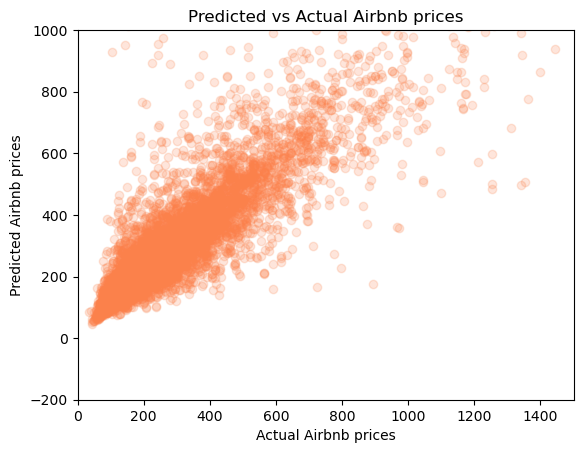

In [56]:
#final model

import matplotlib.pyplot as plt

rfr_model_final = RandomForestRegressor(
    n_estimators = 100,
    random_state=42
)
pipeline = make_pipeline(column_transformer, rfr_model_final)
model_rf = pipeline.fit(x_train,y_train)
y_pred = model_rf.predict(x_test)

plt.scatter(y_test, y_pred, color='#FB814B', alpha=.2)
plt.axis([0,1500,-200,1000])
plt.ylabel('Predicted Airbnb prices')
plt.xlabel('Actual Airbnb prices')
plt.title('Predicted vs Actual Airbnb prices')
plt.show()

In the above graph we plotted the predicted prices with the actual prices. We see that the model is fairly accurate in the price range 200-800 but beyond that we see a lot of inaccuracy. This can be due to less data above that range. 

Lastly, we will see the feature importance of the top 10 features in this model

In [74]:
# Get the list of feature importances
feature_importances = rfr_model_final.feature_importances_

onehot_feature_names = column_transformer.named_transformers_["cat"].get_feature_names(categorical_features)
original_feature_names = x_train.columns.tolist()
features_non_cat = [x for x in original_feature_names if x not in categorical_features]
all_feature_names = onehot_feature_names.tolist() + features_non_cat

importances_df = pd.DataFrame({"feature_name": all_feature_names, "importance": feature_importances})
importances_df.sort_values(by="importance", ascending=False, inplace=True)

print("Top 10 most important features:")
print(importances_df[0:10])

Top 10 most important features:
                  feature_name  importance
24                        dist    0.337918
25                  metro_dist    0.174188
23                    bedrooms    0.087683
17             person_capacity    0.055781
22  guest_satisfaction_overall    0.055404
9                  city_london    0.049378
3               city_amsterdam    0.046846
21          cleanliness_rating    0.045579
10                  city_paris    0.039435
0    room_type_Entire home/apt    0.026591


C:\Users\rahul\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Additional Questions / Conclusion

##### Challenges faced

There was some abiguity regarding the dates of when the data for each city was collected which might have been a major factor when predicting price. In terms of implementation challenges, the data was very clean and I didn't have to do much there. However when playing around with the hyperparameters of the models,  the RandomForestRegressor was taking time to run as it executes each step sequentially and hence is computationally intensive. I could have used other models like Adaboost to reduce the execution time. Secondly, I found it challeneging to tune the hyperparameters to get a good model. Better understanding of the hyperparameters might help to overcome this.

##### 2 potential benefits of the model and 2 potential harms. 

Potential benefits of a model that predicts AirBnB prices could include:
1. Helping guests make more informed decisions. Guests can use the predicted prices to choose accommodations that suit their budget and preferences.
2. Supporting hosts in setting prices. Hosts can use the predicted prices to set prices that are competitive and fair for their property.

However, there are also potential harms that need to be considered:
1. It might reinforcing existing inequalities. If the model is trained on biased data, it could perpetuate existing inequalities by favoring certain locations or types of properties over others.
2. It might also encourage underinvestment in some areas. If the model indicates that prices are low in an area, it could discourage investment in those areas, leading to a lack of options for guests, and hinder the growth of the area.


##### Research question for future work

I think if we have all the reviews of the accommodations along with the dates of reviews we could build a time-series model which would be better and more accurate in predicting the prices of AirBnbs, as the price is a time dependant feature and would also show seasonal changes, which my model does not account for. Also, this could be taken one step further and can be built into a recommender which recommends users accommodation based on their budget and the type of vacation they are looking for. For this we would need additional features.